$$\Huge{\textit{Formation Multi-Perceptron}}$$

In [0]:
#@title Imports et fonctions d'affichages { run: "auto", display-mode: "form" }
import numpy as np
import random
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


def generate_classifier_data_set(poles, random_points=100, spread=0.25, seed=299792458):
    """
    Generates a data set for a simple classifier
    :param poles: the position of the poles of interest
    :param random_points: the number of points per poles
    :param spread: the size of the spread around the poles
    :param seed: the seed used by the random number generator
    :return: the input and output matrices
    """

    np.random.seed(seed)

    x = np.zeros((len(poles) * random_points, 2))
    y = np.zeros((len(poles) * random_points))

    for k in range(len(poles)):
        pole = poles[k]

        for i in range(random_points):
            radius = np.random.uniform(0, spread)
            angle = np.random.uniform(0, 2 * np.pi)

            x[k * random_points + i, 0] = pole[0] + radius * np.cos(angle)
            x[k * random_points + i, 1] = pole[1] + radius * np.sin(angle)
            y[k * random_points + i] = k

    return np.transpose(x), y


def generate_regression_data_set(f, low=0.0, high=1.0, random_points=100, spread=0.5, seed=299792458):
    """
    Generates random points around the curve of the function f
    :param f: the approximated function
    :param low: the starting point of the interval
    :param high: the ending point of the interval
    :param random_points: the number of points
    :param spread: the size of the spread around the curve
    :param seed: the seed used by the random number generator
    :return: the input and output matrices
    """

    np.random.seed(seed)

    x = np.zeros(random_points)
    y = np.zeros(random_points)

    for k in range(random_points):
        x[k] = np.random.normal((low+high)/2, (high-low)/2)
        y[k] = np.random.normal(f(x[k]), spread)

    return x, y


def plot_classifier(x, y):
    """
    Plots the classifier data set as a scatter plot
    :param x: the input matrix
    :param y: the output matrix
    """

    for pole in range(y.shape[0]):
        point_x = []
        point_y = []

        for sample in y.shape[1]:
            if y[sample] == pole:
                point_x.append(x[0, sample])
                point_y.append(x[1, sample])

        plt.scatter(point_x, point_y, label="pole " + str(pole))

    plt.legend()
    plt.show()

    
def plot_classifier_with_approx(X, Y, approx, start=(-1, -1), stop=(1, 1), n=100):
    """
    Plots the classifier data set with the regions predicted by the approximation function
    :param x: the input matrix
    :param y: the output matrix
    :param approx: the approximation function used to classify each point of the plane
    :param start: the staring point
    :param stop: the ending point
    :param n: the number of points per axis
    """

    x = np.linspace(start[0], stop[0], n)
    y = np.linspace(start[1], stop[1], n)
    z = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            z[j, i] = approx((x[i], y[j])) > 0.5

    plt.pcolormesh(x, y, z)

    point_x = []
    point_y = []

    for sample in range(Y.shape[0]):
        if Y[sample] == 1:
            point_x.append(X[0, sample])
            point_y.append(X[1, sample])

    plt.scatter(point_x, point_y, c="black", edgecolors="white")
    
    
    point_x = []
    point_y = []

    for sample in range(Y.shape[0]):
        if Y[sample] == 0:
            point_x.append(X[0, sample])
            point_y.append(X[1, sample])

    plt.scatter(point_x, point_y, c="white", edgecolors="black")
    
    
    
    plt.show()

#Etape 1 : Le neurone

Dans cette section nous allons tout simplement effectuer une régression affine, ce qui correspond au travail d'un neurone avec du biais.

$$h_{b,w}(x^{(i)}) = b + wx^{(i)} $$

N'ayant aucune idée de la valeur de $b$ et $w$, il vaut mieux les initialiser au hasard

## Fonction de coût

Il faut corriger les poids en fonctions des exemples, pour cela, on quantifie l'erreur par une fonction de coût : l'erreur quadratique !

Ce n'est pas du tout la seule façon de faire (on peut aussi penser à l'erreur absolue) et la plupart des problèmes commence par cette question : que veut-on optimiser ? (ici minimiser l'erreur quadratique)

Voici l'erreur quadratique sur un exemple (le facteur 1/2 simplifie les calculs pour plus tard) :

$$J(w, b) = \frac{1}{2}  (h_{w,b}(x^{(i)}) - y^{(i)})^2$$

Ainsi,  en moyennant sur les $m$ exemple d'entraînement on obtient au total:

$$J(w, b) = \frac{1}{2m} \sum_{i=1}^m (h_{w,b}(x^{(i)}) - y^{(i)})^2$$

Pourquoi moyenner plutôt que sommer ? Pour que les nombres n'explosent pas avec beaucoup d'exemples ! Et puis on retombe ainsi dans le cadre très étudié de l'erreur quadratique moyenne.

##La descente de gradient

Puis, on va utiliser cette fonction de coût pour corriger les poids grâce à une fameuse méthode d'optimisation, $\textbf{la descente de gradient}$ :

Pour chaque exemple, on va corriger les poids en descendant la pente ou le gradient :

$$ w := w - \frac{\partial J}{\partial w}(w, b)$$
$$ b := b - \frac{\partial J}{\partial b}(w, b)$$

Et ce en moyennant sur $k$ exemples parmis les $m$ exemples d'entraînement d'où, au total:

$$ w := w - \frac{1}{k}\sum_{i=1}^k \frac{\partial J}{\partial w}(w, b)$$
$$ b := b - \frac{1}{k}\sum_{i=1}^k \frac{\partial J}{\partial b}(w, b)$$

C'est ce que l'on appel faire des $\textbf{batchs}$, ce qui permet d'éviter des pas inutiles.
Ainsi, la taille $k$ des batchs constitue notre 1er hyperparamètre !

Puis, en remplaçant J par son expression, on obtient:

$$ w := w - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)})\frac{\partial h_{w, b}}{\partial w}(w, b)$$
$$ b := b - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)})\frac{\partial h_{w, b}}{\partial b}(w, b)$$

Et donc dans nôtre problème affine :

$$ w := w - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)})x$$
$$ b := b - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)})$$

Beaucoup de blabla mais au final, il ne reste qu'a implémenter la dernière formule !

In [2]:
#@title Implémentation descente one by one

# Implémentation de la régression affine et affichage dynamique avec batchs


# Définition de la fonction qui servira a générer notre set de données
def f(x):
    """
    Fonction affine que l'on va chercher a retrouver par descente de gradient
    :param x: le point d'evaluation de la fonction
    :return: la valeur de la fonction prise en x
    """

    return 2 * x - 1


# On génère notre data set qui sera composé d'une centaine de points eparpillés autour de la courbe de la fonction f
X, Y = generate_regression_data_set(f, 0, 1, 100, 0.3)

# Valeur aléatoires pour le poids et le bias.
weight = np.random.uniform(-1, 1)
bias = np.random.uniform(-1, 1)

parameters = [[weight, bias]]
costs = []

# Implémentation de la régression affine sans batch
for k in range(X.shape[0]):
    x = X[k]
    y = Y[k]
    
    h = weight * x + bias

    cost = 0
    
    for i in range(X.shape[0]):
      cost += (weight * X[i] + bias - Y[i]) ** 2
      
    costs.append(np.log(cost / (2 * X.shape[0])))
    
    cost_derivative = h - y

    weight = weight - cost_derivative * x
    bias = bias - cost_derivative
    
    parameters.append([weight, bias])
    
print("Sans batch, fonction obtenue: f(x)=", weight, "* x +", bias)

Sans batch, fonction obtenue: f(x)= 2.181758006827202 * x + -1.0021571493779027


In [3]:
#@title Animation descente de gradient one by one

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-0.5, 2))
ax1.set_ylim((-2, 2))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r', markersize=15)
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-5, 3))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-0.5,2,100)
    w = parameters[i][0]
    b = parameters[i][1]
    given = w*x + b
  
    prediction.set_data(x, given)
    used_data.set_data([X[i]], [Y[i]])
    cost_point.set_data([i], [costs[i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(parameters)-2, interval=500, blit=True)
HTML(anim.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

In [4]:
#@title Implementation descente de gradient stochastique
# On refait mais en prenant des batchs cette fois ci
weight = np.random.uniform(-1, 1)
bias = np.random.uniform(-1, 1)

parameters = [[weight, bias]]
costs = []

# On règle la taille des batchs
batch_size = 20

# On règle le nombe de fois que l'on veut passer un batch
epochs = 50

# Implémentation de la régression affine avec batchs
batches = []
for k in range(epochs):
    sum_weight = 0
    sum_bias = 0
    batch = []
    
    cost = 0
    
    for i in range(batch_size):
        k = np.random.randint(0, X.shape[0])
        
        x = X[k]
        y = Y[k]
        
        h = weight * x + bias
        
        cost_derivative = h - y

        sum_weight += cost_derivative * x
        sum_bias += cost_derivative
        
        batch.append([x, y])

  
    cost = 0
    
    for i in range(X.shape[0]):
      cost += (weight * X[i] + bias - Y[i]) ** 2
    costs.append(np.log(cost / (2 * X.shape[0])))
        
    #costs.append(np.log(cost / (2 * batch_size)))
    batches.append(batch)
    weight -= sum_weight / batch_size
    bias -= sum_bias / batch_size
    
    parameters.append([weight, bias])

batches = np.array(batches)
print("Avec batch, fonction obtenue: f(x)=", weight, "* x +", bias)


Avec batch, fonction obtenue: f(x)= 2.032851994076927 * x + -1.1306217178202012


In [6]:
#@title Animation descente de gradient stochastique

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-0.5, 2))
ax1.set_ylim((-2, 2))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r', markersize=5)
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-5, 3))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-0.5,2,100)
    w = parameters[i][0]
    b = parameters[i][1]
    given = w*x + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[i,:,0], batches[i,:,1])
    cost_point.set_data([i], [costs[i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(parameters)-2, interval=500, blit=True)
HTML(anim.to_jshtml())

Bon, tout ça c'est bien mais en vrai si on laisse les choses comme ça, notre modèle peut tout a fait diverger ...

On ajoute donc le 2nd hyperparamètre : $\alpha$

$$ w := w - \alpha \frac{\partial J}{\partial w}(w, b)$$
$$ w := w - \frac{\alpha}{k} \sum_{i=1}^k (h_{}(x^{(i)}) - y^{(i)})x_j$$

Il permet de controler la vitesse de gradient: Trop grand et votre algorithme divergera, trop petit et il faudra des siècles  pour converger ... à vous de bien le régler ! (Ou alors on utilise des algos qui le règle automatiquement mais c'est moins drôle)

In [7]:
#@title Implémentation avec alpha trop grand
# On règle la vitesse de la descente de gradient
alpha = 2
weight = np.random.uniform(-1, 1)
bias = np.random.uniform(-1, 1)

parameters = [[weight, bias]]
costs = []

# Implémentation de la régression affine avec contrôle de la vitesse du gradient
batches = []
for k in range(epochs):
    sum_weight = 0
    sum_bias = 0
    batch = []
    
    cost = 0
    
    for i in range(batch_size):
        k = np.random.randint(0, X.shape[0])
        
        x = X[k]
        y = Y[k]
        
        h = weight * x + bias
        
        cost_derivative = h - y

        sum_weight += cost_derivative * x
        sum_bias += cost_derivative
        
        batch.append([x, y])
    
    cost = 0
    
    for i in range(X.shape[0]):
      cost += (weight * X[i] + bias - Y[i]) ** 2

    costs.append(np.log(cost / (2 * X.shape[0])))
    batches.append(batch)
    weight -= sum_weight * alpha / batch_size
    bias -= sum_bias * alpha  / batch_size
    
    parameters.append([weight, bias])

batches = np.array(batches)
print("Avec alpha = {}, fonction obtenue: f(x)={}* x + {}".format(alpha, weight, bias))

Avec alpha = 2, fonction obtenue: f(x)=-34612005123.361725* x + -119318846759.83023


In [8]:
#@title Animation avec alpha trop grand

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-0.5, 2))
ax1.set_ylim((-2, 2))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r', markersize=5)
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-1, 50))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-0.5,2,100)
    w = parameters[i][0]
    b = parameters[i][1]
    given = w*x + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[i,:,0], batches[i,:,1])
    cost_point.set_data([i], [costs[i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(parameters)-2, interval=500, blit=True)
HTML(anim.to_jshtml())

In [9]:
#@title Implémentation avec alpha bien
# On règle la vitesse de la descente de gradient
alpha = 1
weight = np.random.uniform(-1, 1)
bias = np.random.uniform(-1, 1)

parameters = [[weight, bias]]
costs = []

# Implémentation de la régression affine avec contrôle de la vitesse du gradient
batches = []
for k in range(epochs):
    sum_weight = 0
    sum_bias = 0
    batch = []
    cost = 0
    
    for i in range(batch_size):
        k = np.random.randint(0, X.shape[0])
        
        x = X[k]
        y = Y[k]
        
        h = weight * x + bias
        
        cost_derivative = h - y

        sum_weight += cost_derivative * x
        sum_bias += cost_derivative
        
        batch.append([x, y])
    
    cost = 0
    
    for i in range(X.shape[0]):
      cost += (weight * X[i] + bias - Y[i]) ** 2
    
    costs.append(np.log(cost / (2 * X.shape[0])))
    batches.append(batch)
    weight -= sum_weight * alpha / batch_size
    bias -= sum_bias * alpha  / batch_size
    
    parameters.append([weight, bias])

batches = np.array(batches)
print("Avec alpha = {}, fonction obtenue: f(x)={}* x + {}".format(alpha, weight, bias))

Avec alpha = 1, fonction obtenue: f(x)=2.0530617589947746* x + -1.0665596082248445


In [10]:
#@title Animation avec alpha bien
# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-0.5, 2))
ax1.set_ylim((-2, 2))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r', markersize=5)
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-5, 3))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-0.5,2,100)
    w = parameters[i][0]
    b = parameters[i][1]
    given = w*x + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[i,:,0], batches[i,:,1])
    cost_point.set_data([i], [costs[i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(parameters)-2, interval=500, blit=True)
HTML(anim.to_jshtml())

In [11]:
#@title Implémentation avec alpha trop petit
# On règle la vitesse de la descente de gradient
alpha = 0.1
weight = np.random.uniform(-1, 1)
bias = np.random.uniform(-1, 1)

parameters = [[weight, bias]]
costs = []

# Implémentation de la régression affine avec contrôle de la vitesse du gradient
batches = []
for k in range(epochs):
    sum_weight = 0
    sum_bias = 0
    batch = []
    
    for i in range(batch_size):
        k = np.random.randint(0, X.shape[0])
        
        x = X[k]
        y = Y[k]
        
        h = weight * x + bias
        
        cost_derivative = h - y

        sum_weight += cost_derivative * x
        sum_bias += cost_derivative
        
        batch.append([x, y])

    cost = 0
    
    for i in range(X.shape[0]):
      cost += (weight * X[i] + bias - Y[i]) ** 2
    
    costs.append(np.log(cost / (2 * X.shape[0])))
    batches.append(batch)
    weight -= sum_weight * alpha / batch_size
    bias -= sum_bias * alpha  / batch_size
    
    parameters.append([weight, bias])

batches = np.array(batches)
print("Avec alpha = {}, fonction obtenue: f(x)={}* x + {}".format(alpha, weight, bias))

Avec alpha = 0.1, fonction obtenue: f(x)=1.120933736241142* x + -0.4471231200362174


In [12]:
#@title Animation avec alpha trop petit

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-0.5, 2))
ax1.set_ylim((-2, 2))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r', markersize=5)
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-5, 3))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-0.5,2,100)
    w = parameters[i][0]
    b = parameters[i][1]
    given = w*x + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[i,:,0], batches[i,:,1])
    cost_point.set_data([i], [costs[i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(parameters)-2, interval=500, blit=True)
HTML(anim.to_jshtml())

# Etape 2 : Le perceptron

Il faut ajouter des neurones pour créer un perceptron qui est pour l'instant une simple régression à plusieurs variables.

$$h(x) =  b + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + ... + w_nx_n $$

Il faut bien penser à utiliser des vecteurs et matrices plutot que des boucles ! C'est bien plus efficace en temps de calcul et c'est plus lisible au final ! On pose alors pour chaque batch de taille $k$ :

$$X =
\begin{pmatrix}
   x_1^{(1)}  & x_1^{(2)} & \cdots & x_1^{(k)}\\
   x_2^{(1)}  & \ddots\\
   \vdots       &                  & \ddots\\
   x_n^{(1)}  &                 &             &  x_n^{(k)}
\end{pmatrix}
\quad 
W =
\begin{pmatrix}
   w_1  \\
   w_2  \\
   \vdots \\
   w_n
\end{pmatrix}
\quad 
Y =
\begin{pmatrix}
   y^{(1)} & y^{(2)} & \cdots & y^{(k)}
\end{pmatrix}
$$

On a alors pour chaque exemple l'hypothèse:

$$h(X^{(i)}) = b + \:^TWX^{(i)} = z^{(i)}$$

On pose alors $Z$ le vecteur hypothèse linéaire  sur le batch de k exemples:

$$Z = b + \:^TWX$$

La mise a jour des poids est alors :

$$b := b - \frac{\alpha}{k} sum(Z - Y)$$
$$W := W - \frac{\alpha}{k} X   \; ^t   (Z - Y)$$


## Régression polynomiale


Le perceptron linéaire permet entre autre de faire de la régression polynomiale ! (avec $x_j = x^j$)

In [16]:
#@title Implémentation régression polynomiale


def f(x):
    """
    Fonction polynomiale que l'on va chercher a retrouver par descente de gradient
    :param x: le point d'evaluation de la fonction
    :return: la valeur de la fonction prise en x
    """

    return 3 * x ** 2 - 2 * x + 1

X, Y = generate_regression_data_set(f, -2, 2, 100, 1)

# Degrés du polynome qui va approximer les données
n = 2

# Reglage des hyper-paramètres
k = 20
epochs = 100
alpha = 0.03

# Initialisation
b = np.random.uniform(-1, 1)
W = np.random.rand(n, 1) * 2 - 1

# Historique
parameters = [[W, b]]
batches = []
costs = []

for epoch in range(epochs):
  X_batch = np.zeros((n, k))
  Y_batch = np.zeros((1, k))
  batch = []

  for i in range(k):
    rand_i = np.random.randint(0, X.shape[0])

    x = X[rand_i]
    y = Y[rand_i]

    batch.append([x, y])

    for j in range(n):
        X_batch[j, i] = x ** (j + 1)

    Y_batch[0, i] = y
    
  
  cost = 0
  
  for i in range(X.shape[0]):
      a = np.zeros((n, 1))

      for j in range(n):
        a[j, 0] = X[i] ** (j + 1)

      cost += (b + np.dot(np.transpose(W), a) - Y[i])[0, 0] ** 2

  costs.append(np.log(cost / (2 * X.shape[0])))
    
    
  Z = b + np.dot(np.transpose(W), X_batch)

  b = b - alpha / k * np.sum(Z - Y_batch)
  W = W - alpha / k * np.dot(X_batch, np.transpose(Z - Y_batch))

  batches.append(batch) 
  parameters.append([W, b])
  
batches = np.array(batches)
parameters = np.array(parameters)
print("Polynome réel : 3 x^2 - 2 x + 1")
print("Polynome approché : {} x^2 + {} x + {}".format(W[1, 0], W[0, 0], b))



Polynome réel : 3 x^2 - 2 x + 1
Polynome approché : 3.0003424684465343 x^2 + -1.9275930036803397 x + 0.7676742124856639


In [17]:
#@title Animation régression polynomiale

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-2, 3))
ax1.set_ylim((-5, 15))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r')
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-2, 4))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-2,3,100)
    w = [parameters[i][0][k, 0] for k in range(n)]
    b = parameters[i][1]
    given = np.sum(np.array([w[k]*x**(k+1) for k in range(n)]), axis=0) + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[i,:,0], batches[i,:,1])
    cost_point.set_data([i], [costs[i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(parameters)-2, interval=500, blit=True)
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [18]:
#@title Implémentation approximation polynomiale de sin


X, Y = generate_regression_data_set(np.sin, -1, 1, 1000, 0.05)

# Degrés du polynome qui va approximer les données
n = 3

# Reglage des hyper-paramètres
k = 500
epochs = 1000
alpha = 0.03

# Initialisation
b = np.random.uniform(-1, 1)
W = np.random.rand(n, 1) * 2 - 1

# Historique
parameters = [[W, b]]
batches = []
costs = []

for epoch in range(epochs):
    X_batch = np.zeros((n, k))
    Y_batch = np.zeros((1, k))
    batch = []

    for i in range(k):
        rand_i = np.random.randint(0, X.shape[0])
        
        x = X[rand_i]
        y = Y[rand_i]
        
        batch.append([x, y])
  
        for j in range(n):
            X_batch[j, i] = x ** (j + 1)

        Y_batch[0, i] = y

    cost = 0
  
    for i in range(X.shape[0]):
        a = np.zeros((n, 1))

        for j in range(n):
          a[j, 0] = X[i] ** (j + 1)

        cost += (b + np.dot(np.transpose(W), a) - Y[i])[0, 0] ** 2

    costs.append(np.log(cost / (2 * X.shape[0])))
  
    Z = b + np.dot(np.transpose(W), X_batch)

    b = b - alpha / k * np.sum(Z - Y_batch)
    W = W - alpha / k * np.dot(X_batch, np.transpose(Z - Y_batch))
    
    batches.append(batch) 
    parameters.append([W, b])
  
batches = np.array(batches)
parameters = np.array(parameters)

print("Fonction réelle : sin(x)")
print("Dévellopement de sin en 0 : {} x^3 + 0 x^2 + x + 0".format(-1/6))
print("Polynome approché : {} x^3 + {} x^2 + {} x + {}".format(W[2, 0], W[1, 0], W[0, 0], b))



Fonction réelle : sin(x)
Dévellopement de sin en 0 : -0.16666666666666666 x^3 + 0 x^2 + x + 0
Polynome approché : -0.09343844747266113 x^3 + 0.013869980355351358 x^2 + 0.8928829592719589 x + -0.007372618000115984


In [19]:
#@title Animation approximation polynomiale de sin

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-3, 3))
ax1.set_ylim((-1.2, 1.2))
data, = ax1.plot([], [], linestyle='', marker='o', color='b', markersize=2)
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r', markersize=2)
prediction, = ax1.plot([], [], color='g', marker='', lw=2, label='prediction')
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-6, 1))
curve, = ax2.plot([], [], color='b')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    curve.set_data(range(len(costs)), costs)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-3,3,100)
    w = [parameters[3*i][0][k, 0] for k in range(n)]
    b = parameters[3*i][1]
    given = np.sum(np.array([w[k]*x**(k+1) for k in range(n)]), axis=0) + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[3*i,:,0], batches[3*i,:,1])
    cost_point.set_data([3*i], [costs[3*i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=299, interval=500, blit=True)
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

Mais cela ne marche pas toujours ! En effet, si on prend $n$ grand, on peut faire n'importe quoi !



In [44]:
#@title Exemple d'overfitting
X = np.array(np.linspace(-1.5,1.7, 6))
Y = f(X)

# Set pour la cross validation
X_test = np.array([-1, 2, 2.4])
Y_test = f(X_test)

# Degrés du polynome qui va approximer les données
n = 6

# Reglage des hyper-paramètres
k = 6
epochs = 10000
alpha = 0.003

# Initialisation
b = np.random.uniform(-1, 1)
W = np.random.rand(n, 1) * 2 - 1

# Historique
parameters = [[W, b]]
batches = []
costs = []
cross_validations = []

for epoch in range(epochs):
  X_batch = np.zeros((n, k))
  Y_batch = np.zeros((1, k))
  batch = []

  for i in range(k):
    rand_i = np.random.randint(0, X.shape[0])

    x = X[rand_i]
    y = Y[rand_i]

    batch.append([x, y])

    for j in range(n):
        X_batch[j, i] = x ** (j + 1)

    Y_batch[0, i] = y

  cost = 0

  for i in range(X.shape[0]):
    a = np.zeros((n, 1))

    for j in range(n):
      a[j, 0] = X[i] ** (j + 1)

    cost += (b + np.dot(np.transpose(W), a) - Y[i])[0, 0] ** 2

  costs.append(np.log(cost / (2 * X.shape[0])))

  cross_validation = 0

  for i in range(X_test.shape[0]):
    a = np.zeros((n, 1))

    for j in range(n):
      a[j, 0] = X_test[i] ** (j + 1)

    cross_validation += (b + np.dot(np.transpose(W), a) - Y_test[i])[0, 0] ** 2

  cross_validations.append(np.log(cross_validation / (2 * X_test.shape[0])))

  Z = b + np.dot(np.transpose(W), X_batch)

  b = b - alpha / k * np.sum(Z - Y_batch)
  W = W - alpha / k * np.dot(X_batch, np.transpose(Z - Y_batch))

  batches.append(batch) 
  parameters.append([W, b])
  
batches = np.array(batches)
parameters = np.array(parameters)
print("Polynome réel : 3 x^2 - 2 x + 1")
print("Polynome approché : {} + {}".format(np.flip(W, 0), b))


Polynome réel : 3 x^2 - 2 x + 1
Polynome approché : [[-0.19732659]
 [ 0.05986014]
 [ 0.75618363]
 [-0.11220685]
 [ 2.30193515]
 [-1.96958129]] + 1.1144692697754353


In [45]:
#@title Animation régression polynomiale

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-2, 3))
ax1.set_ylim((-5, 15))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
val_data, = ax1.plot([], [], linestyle='', marker='o', color='g')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r')
prediction, = ax1.plot([], [], color='g', marker='', lw=2)
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-8, 16))
curve, = ax2.plot([], [], color='b', label='cout_entrainement')
validation_curve, =ax2.plot([], [], color='g', label='cout_validation')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    val_data.set_data(X_test[:], Y_test[:])
    curve.set_data(range(len(costs)), costs)
    validation_curve.set_data(range(len(cross_validations)), cross_validations)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-2,3,100)
    w = [parameters[100*i][0][k, 0] for k in range(n)]
    b = parameters[100*i][1]
    given = np.sum(np.array([w[k]*x**(k+1) for k in range(n)]), axis=0) + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[100*i,:,0], batches[100*i,:,1])
    cost_point.set_data([100*i, 100*i], [costs[100*i], cross_validations[100*i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=99, interval=500, blit=True)
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

A trop chercher à coller aux données d'entrainement, on crée des modèles a très forte variance ! Inversement, en généralisant trop, on crée un modèle à fort biais.

Ce dilème est connu sous le nom de dilème biais-variance :
https://www.youtube.com/watch?v=Jeyb9BbKtpE&t=3s

En machine learning, trop coller aux données d'entrainement est appelé $\textbf{Overfitting}$.

Pour contrôller ce phénomène , on ajoute le 2ème hyperparamètre : $\lambda$ le coefficient de régularisation

$$J(w, b) = \frac{1}{2k} \sum_{i=1}^k (h_{w,b}(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2} \sum_{j=1}^n w_j^2 $$

Il permet d'implémenter le principe du razoir d'Occam : les modèles les plus simple sont souvent les meilleurs.

Cela se constate particulièrement sur la régression polynomiale !


Et ainsi la mise à jour des poids devient:
$$b := b - \frac{\alpha}{k} sum(Z - Y)$$
$$W := W -  \alpha\Bigg( \frac{1}{k} X  \times \; ^t  (Z - Y)   +\lambda W \Bigg)$$

Il existe d'autres méthodes pour réduire l'overfitting telles que la validation croisée que l'on détaillera pas pour le moment.



In [42]:
#@title Implémentation régularisation

# Degrés du polynome qui va approximer les données
n = 6

# Reglage des hyper-paramètres
k = 6
epochs = 10000
alpha = 0.003
lamb = 0.1

# Initialisation
b = np.random.uniform(-1, 1)
W = np.random.rand(n, 1) * 2 - 1

# Historique
parameters = [[W, b]]
batches = []
costs = []
cross_validations = []
for epoch in range(epochs):
  X_batch = np.zeros((n, k))
  Y_batch = np.zeros((1, k))
  batch = []

  for i in range(k):
    rand_i = np.random.randint(0, X.shape[0])

    x = X[rand_i]
    y = Y[rand_i]

    batch.append([x, y])

    for j in range(n):
        X_batch[j, i] = x ** (j + 1)

    Y_batch[0, i] = y
    
  cost = 0

  for i in range(X.shape[0]):
    a = np.zeros((n, 1))

    for j in range(n):
      a[j, 0] = X[i] ** (j + 1)

    cost += (b + np.dot(np.transpose(W), a) - Y[i])[0, 0] ** 2

  costs.append(np.log(cost / (2 * X.shape[0])))

  cross_validation = 0

  for i in range(X_test.shape[0]):
    a = np.zeros((n, 1))

    for j in range(n):
      a[j, 0] = X_test[i] ** (j + 1)

    cross_validation += (b + np.dot(np.transpose(W), a) - Y_test[i])[0, 0] ** 2

  cross_validations.append(np.log(cross_validation / (2 * X_test.shape[0])))

  Z = b + np.dot(np.transpose(W), X_batch)

  b = b - alpha / k * np.sum(Z - Y_batch)
  W = W - alpha * (np.dot(X_batch, np.transpose(Z - Y_batch)) / k + lamb * W)

  batches.append(batch) 
  parameters.append([W, b])

  
batches = np.array(batches)
parameters = np.array(parameters)
print("Polynome réel : 3 x^2 - 2 x + 1")
print("Polynome approché : {} + {}".format(np.transpose(np.flip(W, 0))[0, :], b))


Polynome réel : 3 x^2 - 2 x + 1
Polynome approché : [-0.02015803 -0.00168017  0.7367235  -0.4479577   1.07640056 -1.12367998] + 1.6511081885824204


In [43]:
#@title Animation régression polynomiale

# First set up the figure, the axes, and the plot element
fig = plt.figure(1)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.close()

ax1.set_xlim((-2, 3))
ax1.set_ylim((-5, 15))
data, = ax1.plot([], [], linestyle='', marker='o', color='b')
val_data, = ax1.plot([], [], linestyle='', marker='o', color='g')
used_data, = ax1.plot([], [], linestyle='', marker='o', color='r')
prediction, = ax1.plot([], [], color='g', marker='', lw=2)
ax1.set_title("Modèle")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax2.set_xlim((0, len(costs)))
ax2.set_ylim((-8, 16))
curve, = ax2.plot([], [], color='b', label='cout_entrainement')
validation_curve, =ax2.plot([], [], color='g', label='cout_validation')
cost_point, = ax2.plot([], [], linestyle='', marker='o', color='r', markersize=5)
ax2.set_title("Evolution du coût")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Fonction de coût (log)")

# initialization function: plot the background of each frame
def init():
    data.set_data(X[:], Y[:])
    val_data.set_data(X_test[:], Y_test[:])
    curve.set_data(range(len(costs)), costs)
    validation_curve.set_data(range(len(cross_validations)), cross_validations)
    return (data, curve,)
  
# animation function: this is called sequentially
def animate(i):
    x = np.linspace(-2,3,100)
    w = [parameters[100*i][0][k, 0] for k in range(n)]
    b = parameters[100*i][1]
    given = np.sum(np.array([w[k]*x**(k+1) for k in range(n)]), axis=0) + b
  
    prediction.set_data(x, given)
    used_data.set_data(batches[100*i,:,0], batches[100*i,:,1])
    cost_point.set_data([100*i, 100*i], [costs[100*i], cross_validations[100*i]])
    return (prediction, used_data,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=99, interval=500, blit=True)
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

## Régression logistique uniclasse

Puis modéliser des fonction plus générales, il faut ajouter des non linéarités, on compose alors avec une $\textbf{fonction d'activation}$ $g$ non linéaire (sigmoid, ReLU, tanh, ...)

$$h_{W, b}(X^{(i)}) = g(b + w_1x_1 + w_2x_2 + ... + w_nx_n) = g(z^{(i)}) $$

On rappel la mise a jour des poids formelle :

$$ b := b - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)})\frac{\partial h_{w, b}}{\partial b}(w, b)$$
$$ w := w - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)})\frac{\partial h_{w, b}}{\partial w_j}(w, b)$$

Qui devient, par dérivée d'une composée :

$$ b := b - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)}) \times g'(z^{(i)})$$
$$ w_j := w_j - \frac{1}{k} \sum_{i=1}^k (h_{w, b}(x^{(i)}) - y^{(i)}) \times x_j \, g'(z^{(i)})  + \lambda w_j$$


Et matriciellement : 

$$b := b - \frac{\alpha}{k} (Z - Y) \;^tg'(Z)$$
$$W := W -  \alpha \Bigg( \frac{1}{k} X  \times \; ^t \Big( (Z - Y) .* \, g'(Z) \Big)   +\lambda W \Bigg)$$

Ainsi, on peut créer nos premiers classifieurs from scratch !

Précision du modèle sur les données d'entrainement 88.5 %


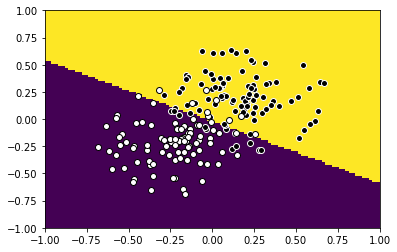

In [34]:
#@title Exemple de classification 0/1

# Definition de notre fonction d'activation
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(- x))


def sigmoid_derivative(x):
  s = sigmoid(x)
  
  return s * (1 - s)


X, Y = generate_classifier_data_set([[-0.2, -0.2], [0.2, 0.2]], spread=0.5, seed=456)

# Reglage des hyper-paramètres
k = 200
epochs = 1000
alpha = 0.9

# Initialisation
b = np.random.uniform(-1, 1)
W = np.random.rand(2, 1) * 2 - 1

for epoch in range(epochs):
  X_batch = np.zeros((2, k))
  Y_batch = np.zeros((1, k))
  
  batch = random.sample(range(Y.shape[0]), k)
   
  X_batch[0, :] = X[0, batch]
  X_batch[1, :] = X[1, batch]

  Y_batch[0, :] = Y[batch]

  Z = b + np.dot(np.transpose(W), X_batch)
  Z_prime = sigmoid_derivative(Z)

  b = b - alpha / k * np.dot(sigmoid(Z) - Y_batch, np.transpose(Z_prime))
  W = W - alpha * (np.dot(X_batch, np.transpose((Z - Y_batch) * Z_prime)) / k)
    
    
def approx(point):
  predict = sigmoid(b + np.dot(np.transpose(W), np.array(point).transpose()))[0, 0]
  
  return predict


guess = 0

for k in range(200):
  point = np.transpose(X)[k]
  y = np.transpose(Y)[k]
  
  if (approx(point) > 0.5 and y > 0.5) or (approx(point) < 0.5 and y < 0.5):
    guess += 1
    
print("Précision du modèle sur les données d'entrainement", guess / 2, "%")


plot_classifier_with_approx(X, Y, approx)
  

## Régression logistique multiclasses

Cependant on ne peut que faire de la classification binaire et mauvaise en plus ! 
En effet la régression n'est pas un substitu total de la classification ! Il nous faut donc ruser !

Pour cela, on va modifier la sortie, au lieu d'un simple nombre, la sortie sera un vecteur où chaque coordonnée représente l'appartenance à une classe bien particulière !

Ainsi, nos sorties seront :

$$H_\theta(X) =
\begin{pmatrix}
    h_\theta(X)_1\\
    h_\theta(X)_2\\
    h_\theta(X)_3\\
    \vdots\\
    h_\theta(X)_p
\end{pmatrix}
\quad
Y =
\begin{pmatrix}
   0\\
   1\\
   0 \\
   \vdots\\
   0
\end{pmatrix}
$$

Avec les notations précédentes, on a maintenant une tableau de poids à trois dimentions !
Alors pas de panique ! On ne va pas tout de suite utiliser *np.einsum* et les notations d'Einstein : https://www.drgoulu.com/2016/01/17/einsum/#.XGLu4FVKjIU

On va simplement faire une boucle moche sur chaque batch, ce qui coutera un peu de temps de calcul, mais qui sera beaucoup plus simple à implémenter !

On a donc notre nouvelle matrice de poids de taille $n \times p$ et un vecteur biais de taille $p$ :

$$X =
\begin{pmatrix}
   x_1\\
   x_2\\
   \vdots\\
   x_n
\end{pmatrix}
\quad 
W =
\begin{pmatrix}
   w_{1,1}     &  w_{1,2} & \cdots & w_{1,p}\\
   w_{2,1}     & \ddots   &            &  \vdots\\
   \vdots       &                & \ddots & \vdots\\
   w_{n,1}     &  \cdots   &  \cdots & w_{n,p}
\end{pmatrix}
\quad 
B =
\begin{pmatrix}
   b_1\\
   b_2\\
   \vdots\\
   b_p
\end{pmatrix}
\quad
Y =
\begin{pmatrix}
   y_1\\
   y_2\\
   \vdots\\
   y_p
\end{pmatrix}
\quad 
$$

Et notre $Z$ intermédiaire devient de taille $p$:

$$Z = B + \:^TWX$$

Et la mise a jour des poids devient:

$\text{For in range}(1, k+1):$
$$b := b - \frac{\alpha}{k} \;^t (Z^{(i)} - Y^{(i)}) g'(Z^{(i)})$$
$$W := W -  \alpha \Bigg( \frac{1}{k} X^{(i)}  \times \; ^t \Big( (Z^{(i)} - Y^{(i)}) .* \, g'(Z^{(i)}) \Big)   +\lambda W \Bigg)$$



Précision du modèle sur les données d'entrainement 87.5 %


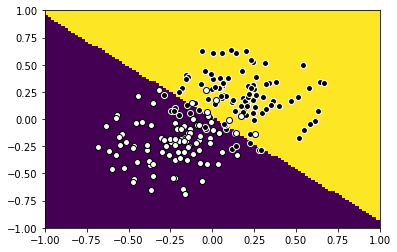

In [35]:
#@title Exemple de classification binaire en effectuant une regression multiclasse

X, Y_single = generate_classifier_data_set([[-0.2, -0.2], [0.2, 0.2]], spread=0.5, seed=456)

Y = np.zeros((2, 200), dtype=float)

for k in range(200):
  if Y_single[k] < 0.5:
    Y[0, k] = 1
  else:
    Y[1, k] = 1

# Reglage des hyper-paramètres
k = 200
epochs = 1000
alpha = 0.1
lamb = 0.1

# Reglages n et p
p = 2 # On a 2 classes 0 et 1
n = 2 # Dimension d'entrée

# Initialisation
B = np.random.rand(p, 1) * 2 - 1
W = np.random.rand(n, p) * 2 - 1

for epoch in range(epochs):
  sum_B = np.zeros((p, 1))
  sum_W = np.zeros((n, p))

  for i in range(k):
    rand_i = np.random.randint(0, X.shape[1])
    
    X_batch = X[:, rand_i].transpose().reshape(n, 1)
    Y_batch = Y[:, rand_i].transpose().reshape(p, 1)
    
    Z = B + np.dot(np.transpose(W), X_batch)
    Z_prime = sigmoid_derivative(Z)
    

    sum_B += (Z - Y_batch) * Z_prime
    sum_W += np.dot(X_batch, np.transpose((Z - Y_batch) * Z_prime))
    
  B = B - alpha / k * sum_B
  W = W - alpha * (sum_W / k + lamb * W)


def approx(point):
  predict = sigmoid(b + np.dot(np.transpose(W), np.array(point).transpose()))
  
  if predict[0, 0] < predict[0, 1]:
    return 1
  
  return 0


guess = 0

for k in range(200):
  point = np.transpose(X)[k]
  a = np.transpose(Y)[k]
  
  y = 0
  
  if a[0] < a[1]:
    y = 1
  
  if (approx(point) > 0.5 and y > 0.5) or (approx(point) < 0.5 and y < 0.5):
    guess += 1
    
print("Précision du modèle sur les données d'entrainement", guess / 2, "%")


plot_classifier_with_approx(X, Y_single, approx)
  

Un test classique pour cela est la classification des chiffres manuscrits !

Ici on utilise Keras pour charger le MNIST dans Colab et on normalise les données afin d'avoir des valeurs qui restent dans des ordres de grandeurs similaires afin de rendre l'apprentissage (beaucoup) plus efficace

In [36]:
#@title Regression logistique multiclasse sur le MNIST

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = x_train.reshape(60000, 784).transpose() / 255.
Y = np.zeros((60000, 10))

for i in range(60000):
  Y[i, y_train[i]] = 1

Y = np.transpose(Y)  
  
# Reglage des hyper-paramètres
k = 200
epochs = 10000
alpha = 0.1
lamb = 0.1

# Reglages n et p
p = 10  # On a 10 classes 0...9
n = 784 # Dimension d'entrée

# Initialisation
B = np.random.rand(p, 1) * 2 - 1
W = np.random.rand(n, p) * 2 - 1

for epoch in range(epochs):
  sum_B = np.zeros((p, 1))
  sum_W = np.zeros((n, p))

  for i in range(k):
    rand_i = np.random.randint(0, X.shape[1])
    
    X_batch = X[:, rand_i].transpose().reshape(n, 1)
    Y_batch = Y[:, rand_i].transpose().reshape(p, 1)
    
    Z = B + np.dot(np.transpose(W), X_batch)
    Z_prime = sigmoid_derivative(Z)
    

    sum_B += (Z - Y_batch) * Z_prime
    sum_W += np.dot(X_batch, np.transpose((Z - Y_batch) * Z_prime))
    
  B = B - alpha / k * sum_B
  W = W - alpha * (sum_W / k + lamb * W)

# On récupère le set de test (données que l'on à jamais montré a notre perceptron)
X = x_test.reshape(10000, 784).transpose() / 255.
Y = np.zeros((10000, 10))

for i in range(10000):
  Y[i, y_test[i]] = 1

Y = np.transpose(Y)  
  
guesses = 0

# On test sur chacun des exemples (batch de taille 10000 en gros)
for k in range(10000):
  X_batch = X[:, k].transpose().reshape(n, 1)
  Y_batch = Y[:, k].transpose().reshape(p, 1)
  
  guess = sigmoid(B + np.dot(np.transpose(W), X_batch))
  
  index = 0
  
  for i in range(10):
    if guess[i, 0] > guess[index, 0]:
      index = i
  
  if Y_batch[index, 0] == 1:
    guesses += 1

print("Précision sur le set de test:", guesses / 100, "%")

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
Précision sur le set de test: 83.52 %


Cependant cela n'est pas suffisant pour tout type de fonction (ce serait trop simple), par exemple le Xor !

On a donc besoin du Multi-Perceptron !

In [39]:
#@title Echec sur le XOR
X = np.array([[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 0.0, 1.0]])
Y = np.array([[0.0, 1.0, 1.0, 0.0]])

# Reglage des hyper-paramètres
k = 200
epochs = 10000
alpha = 0.1

# Reglages n et p
p = 1 # On a seulement une classe (boolean)
n = 2 # Dimension d'entrée

# Initialisation
B = np.random.rand(p, 1) * 2 - 1
W = np.random.rand(n, p) * 2 - 1

for epoch in range(epochs):
  sum_B = np.zeros((p, 1))
  sum_W = np.zeros((n, p))

  for i in range(k):
    rand_i = np.random.randint(0, X.shape[1])
    
    X_batch = X[:, rand_i].transpose().reshape(n, 1)
    Y_batch = Y[:, rand_i].transpose().reshape(p, 1)
    
    Z = B + np.dot(np.transpose(W), X_batch)
    Z_prime = sigmoid_derivative(Z)
    

    sum_B += (Z - Y_batch) * Z_prime
    sum_W += np.dot(X_batch, np.transpose((Z - Y_batch) * Z_prime))
    
  B = B - alpha / k * sum_B
  W = W - alpha / k * sum_W

for k in range(4):
  X_batch = X[:, k].transpose().reshape(n, 1)
  Y_batch = Y[:, k].transpose().reshape(p, 1)
  
  guess = sigmoid(B + np.dot(np.transpose(W), X_batch))
  
  print("Prediction pour", X_batch.transpose(), ":", guess, ", attendu:", Y_batch)

Prediction pour [[0. 0.]] : [[0.62430572]] , attendu: [[0.]]
Prediction pour [[0. 1.]] : [[0.62484374]] , attendu: [[1.]]
Prediction pour [[1. 0.]] : [[0.62335885]] , attendu: [[1.]]
Prediction pour [[1. 1.]] : [[0.62389742]] , attendu: [[0.]]
